## Mini PJT

- 해당 데이터를 고객 단위로 묶어야 합니다.


- 데이터를 정제해서, 월별/고객별로 재정렬이 필요합니다. (aggregation)


- row가 고객별 데이터로 묶이고 난 다음, 고객들을 유형별로 나눠봅니다.


- 여러 가지 클러스터링 알고리즘을 사용하여, 결과를 테스트해봅니다.


- 클러스터링을 위한 전처리부터, 평가까지 모든 항목을 하나하나 살펴보면서 데이터를 뜯어봅니다.

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

### 1. 데이터 불러오기 

In [1]:
# instacart 데이터를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
aisles = pd.read_csv("data/instacart-market-basket-analysis/aisles.csv")
departments = pd.read_csv("data/instacart-market-basket-analysis/departments.csv")
prior = pd.read_csv("data/instacart-market-basket-analysis/order_products__prior.csv")
train = pd.read_csv("data/instacart-market-basket-analysis/order_products__train.csv")
orders = pd.read_csv("data/instacart-market-basket-analysis/orders.csv")
products = pd.read_csv("data/instacart-market-basket-analysis/products.csv")

In [2]:
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [3]:
# 불러온 모든 테이블을 합칩니다.
temp = pd.merge(orders, prior_sample, on="order_id")
temp = pd.merge(temp, products, on="product_id")
temp = pd.merge(temp, aisles, on="aisle_id")
temp = pd.merge(temp, departments, on="department_id")
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


### 2. EDA

In [4]:
# 1만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
#temp.user_id.value_counts() # 972명의 고객.
#temp.product_name.value_counts()
#temp.aisle.value_counts()
#temp.department.value_counts()
#temp.order_dow.value_counts()
#temp.order_hour_of_day.value_counts()

### 3. 데이터 전처리

- 데이터를 transaction 단위로 변경합니다.

- 각자의 방법대로 데이터의 단위를 정해봅시다.


> User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다. e.g. pd.crosstab, CountVectorizer

In [5]:
# transaction->user-level 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리합니다.
# 1. Department(v)     2. Aisle      3. Product_name

X = pd.crosstab(index=temp.user_id, columns=temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### 4. 클러스터링 모델 적용하기

- 사용하는 클러스터링 모델은 KMeans로 합니다.

(원하시면 AgglomerativeClustering, DBSCAN, SpectralClustering을 사용해보셔도 됩니다. 단, 시간이 매우매우 오래 걸릴수 있으니 주의하세요..)

**[K-Means]**

- Elbow method를 이용하여 최적의 K값을 찾아보세요.


- sparse한 특징을 가지는 데이터를 클러스터링 하기 위해서는 어떤 기법을 사용해야 할까요?


- 클러스터링 결과를 시각화해보고, 실루엣 지수도 계산해봅시다.

In [6]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# tSNE : 시각화용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

C:\Users\munin\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\munin\anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


array([[-18.875029  ,  17.712442  ],
       [-24.119043  , -10.548693  ],
       [-22.381355  ,   6.7466903 ],
       ...,
       [-13.127854  ,  -0.19081466],
       [-25.177298  ,  21.905195  ],
       [  6.612099  , -12.822943  ]], dtype=float32)

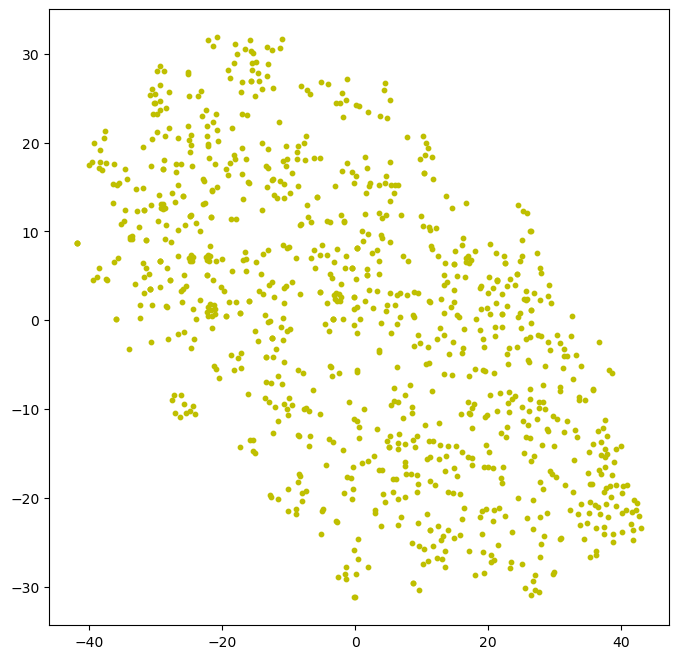

In [8]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [9]:
# K-means를 돌려봅시다.
from sklearn.cluster import KMeans                    # 1. K-means
from sklearn.cluster import AgglomerativeClustering   # 2. Hierarchical Agglomerative Clustering
from sklearn.cluster import DBSCAN                    # 3. DBSCAN
from sklearn.cluster import SpectralClustering        # 4. Spectral Clustering

from sklearn.metrics import silhouette_score

model = KMeans(n_clusters=4)
model2 = KMeans(n_clusters=2)
# unsupervised setting
pred = model.fit_predict(X)
pred2 = model2.fit_predict(X)
print("Silhouette Score : %.4f" % silhouette_score(X, pred))
print("Silhouette Score : %.4f" % silhouette_score(X, pred2))

Silhouette Score : 0.1911
Silhouette Score : 0.3641


In [10]:
# elbow method
sse = []
silhouettes = []

for K in range(2, 11):
  model = KMeans(n_clusters=K) # K : 2 ~ 10
  pred = model.fit_predict(X)
  sse.append(model.inertia_) # SSE
  silhouettes.append(silhouette_score(X, pred))

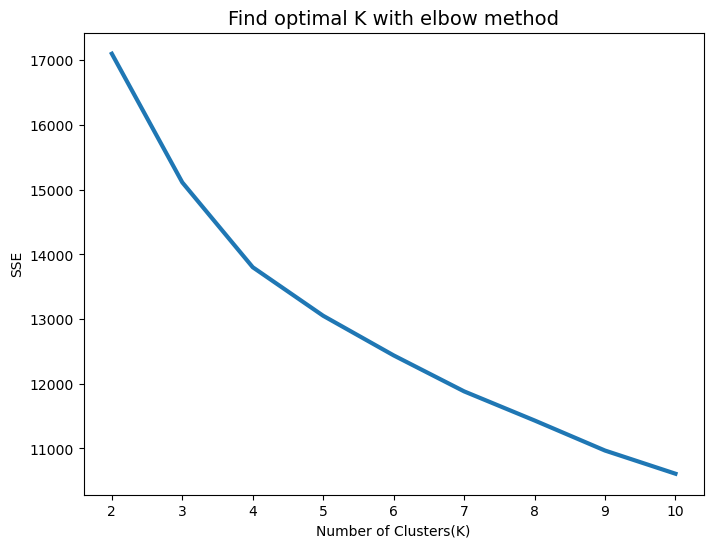

In [11]:
# 최적의 K는 어떻게 구할까요?
# Elbow method : 정해진 K에 대해서 SSE를 계산한 다음, SSE가 가장 많이 꺾이는 K(elbow)가 optimal K라고 판단하는 방법.

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 11), sse, lw=3)
plt.show()

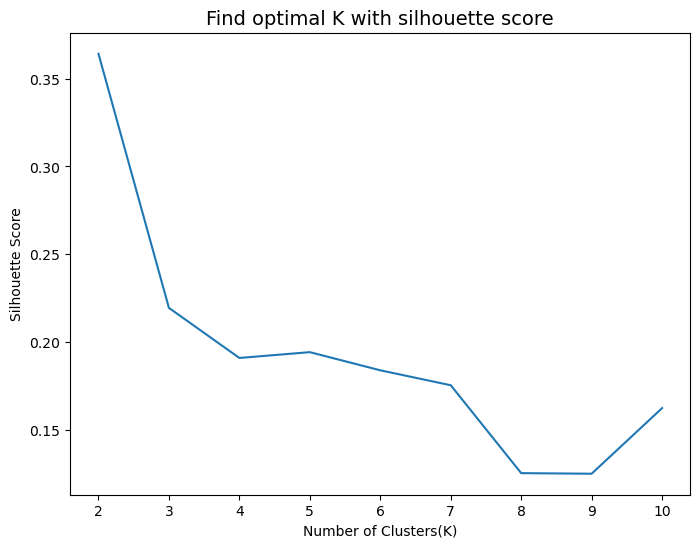

In [12]:
# Silhouette score : 같은 클러스터에 속하는 데이터중 가장 먼 데이터와의 거리와 다른 클러스터에 속하는 데이터 중 가장 가까운 데이터와의 거리 비율을 계산한 지표. [-1, 1]
# Reference : https://en.wikipedia.org/wiki/Silhouette_(clustering)

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 11), silhouettes)
plt.show()

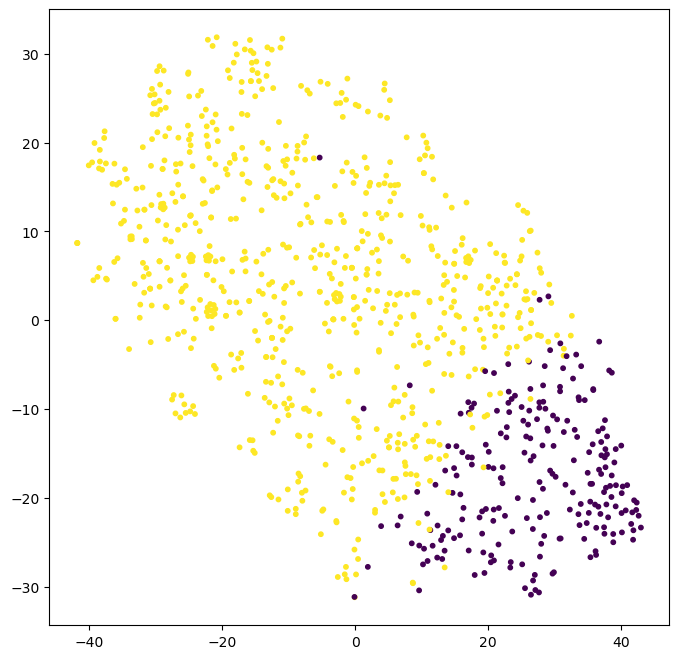

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred2, cmap="viridis")
plt.show()

In [14]:
# see summary
X["cluster_label"] = pred2
X["Cluster_label"] = pred
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster_label,Cluster_label
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,5
503,0,0,0,0,1,0,2,1,0,0,...,1,0,0,1,0,0,2,0,1,5
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,5
1059,0,0,3,0,3,0,0,8,0,0,...,2,0,0,2,0,0,8,2,0,0
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,2,2,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,5
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,4,1,1,4
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,1,5


In [15]:
group1 = X.loc[X.Cluster_label == 0, :]
group2 = X.loc[X.Cluster_label == 1, :]
group3 = X.loc[X.Cluster_label == 2, :]
group4 = X.loc[X.Cluster_label == 3, :]
print(group1.shape, group2.shape, group3.shape, group4.shape)

(27, 23) (77, 23) (71, 23) (32, 23)


In [16]:
group1.mean()

department
alcohol            0.000000
babies             0.259259
bakery             1.148148
beverages          1.037037
breakfast          0.740741
bulk               0.000000
canned goods       0.555556
dairy eggs         7.555556
deli               0.629630
dry goods pasta    1.185185
frozen             1.333333
household          0.333333
international      0.222222
meat seafood       0.592593
missing            0.037037
other              0.037037
pantry             1.777778
personal care      0.259259
pets               0.000000
produce            4.703704
snacks             2.185185
cluster_label      0.111111
Cluster_label      0.000000
dtype: float64

In [17]:
group2.mean()

department
alcohol            0.025974
babies             0.000000
bakery             0.285714
beverages          3.545455
breakfast          0.376623
bulk               0.000000
canned goods       0.324675
dairy eggs         1.363636
deli               0.207792
dry goods pasta    0.168831
frozen             0.818182
household          0.428571
international      0.064935
meat seafood       0.155844
missing            0.000000
other              0.038961
pantry             0.337662
personal care      0.207792
pets               0.025974
produce            1.025974
snacks             1.038961
cluster_label      0.987013
Cluster_label      1.000000
dtype: float64

In [18]:
group3.mean()

department
alcohol            0.014085
babies             0.422535
bakery             0.380282
beverages          0.605634
breakfast          0.239437
bulk               0.028169
canned goods       0.676056
dairy eggs         1.760563
deli               0.352113
dry goods pasta    0.267606
frozen             0.746479
household          0.098592
international      0.154930
meat seafood       0.408451
missing            0.000000
other              0.014085
pantry             0.704225
personal care      0.126761
pets               0.014085
produce            7.394366
snacks             0.380282
cluster_label      0.000000
Cluster_label      2.000000
dtype: float64

In [19]:
group4.mean()

department
alcohol            0.03125
babies             0.18750
bakery             1.03125
beverages          2.00000
breakfast          0.37500
bulk               0.00000
canned goods       0.87500
dairy eggs         3.93750
deli               1.18750
dry goods pasta    0.68750
frozen             2.53125
household          0.93750
international      0.09375
meat seafood       0.71875
missing            0.00000
other              0.00000
pantry             1.12500
personal care      0.12500
pets               0.06250
produce            8.12500
snacks             3.28125
cluster_label      0.00000
Cluster_label      3.00000
dtype: float64